In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/isic-2018-jpg-256x256-resized/train-metadata.csv
/kaggle/input/isic-2018-jpg-256x256-resized/.ipynb_checkpoints/dataset-metadata-checkpoint.json
/kaggle/input/isic-2018-jpg-256x256-resized/train-image/image/ISIC_0030912.jpg
/kaggle/input/isic-2018-jpg-256x256-resized/train-image/image/ISIC_0035342.jpg
/kaggle/input/isic-2018-jpg-256x256-resized/train-image/image/ISIC_0028933.jpg
/kaggle/input/isic-2018-jpg-256x256-resized/train-image/image/ISIC_0030585.jpg
/kaggle/input/isic-2018-jpg-256x256-resized/train-image/image/ISIC_0033697.jpg
/kaggle/input/isic-2018-jpg-256x256-resized/train-image/image/ISIC_0030062.jpg
/kaggle/input/isic-2018-jpg-256x256-resized/train-image/image/ISIC_0031213.jpg
/kaggle/input/isic-2018-jpg-256x256-resized/train-image/image/ISIC_0027799.jpg
/kaggle/input/isic-2018-jpg-256x256-resized/train-image/image/ISIC_0027960.jpg
/kaggle/input/isic-2018-jpg-256x256-resized/train-image/image/ISIC_0028872.jpg
/kaggle/input/isic-2018-jpg-256x256-resized/train-i

# Inspect the data layout

In [3]:
from fastai.vision.all import *


In [4]:
from pathlib import Path
import os
import pandas as pd

# 1. Base path
base_path = Path('/kaggle/input/isic-2018-jpg-256x256-resized')


# Show folder structure
print(os.listdir(base_path))


['train-metadata.csv', '.ipynb_checkpoints', 'train-image']


In [5]:
print("Folder contents:")
for item in base_path.iterdir():
    
    print("-", item.name)
for item in base_path.iterdir():
    print(item)

Folder contents:
- train-metadata.csv
- .ipynb_checkpoints
- train-image
/kaggle/input/isic-2018-jpg-256x256-resized/train-metadata.csv
/kaggle/input/isic-2018-jpg-256x256-resized/.ipynb_checkpoints
/kaggle/input/isic-2018-jpg-256x256-resized/train-image


In [6]:
import pandas as pd
from pathlib import Path

df = pd.read_csv(base_path/'train-metadata.csv')

print(df.columns)
df.head()


Index(['Unnamed: 0', 'isic_id', 'patient_id', 'target'], dtype='object')


,Unnamed: 0,isic_id,patient_id,target
0,0,ISIC_0028498,HAM_0000000,0.0
1,1,ISIC_0027859,HAM_0000001,0.0
2,2,ISIC_0034246,HAM_0000002,1.0
3,3,ISIC_0027886,HAM_0000003,0.0
4,4,ISIC_0024645,HAM_0000004,0.0


In [7]:
from pathlib import Path

img_dir = Path('/kaggle/input/isic-2018-jpg-256x256-resized/train-image')
recursive_search = list(img_dir.rglob('*.jpg')) # All .jpg files including subfolders


In [8]:
# A dict in the form 'ISIC_00xxxx' → Path(...)
available_images = {f.stem: f for f in recursive_search}


# Create the DataBlock and Dataloaders

In [9]:
from fastai.vision.all import *
import pandas as pd
from pathlib import Path

# 1. Keep only images that actually exist
df = df[df['isic_id'].isin(available_images.keys())].copy()

# 2. Create by matching the image_path column
df['image_path'] = df['isic_id'].map(available_images)

# Prepare labels as strings
df['label'] = df['target'].map({0.0: 'benign', 1.0: 'malignant'})


# 5. DataBlock 
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('image_path'),
    get_y=ColReader('label'),
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(460),  # Presize
    batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]
)

# 6. DataLoaders
dls = dblock.dataloaders(df, bs=32)


# Inspect the Data

In [10]:
print("Labels:", dls.vocab)
dblock.summary(df)


Labels: ['benign', 'malignant']
Setting-up type transforms pipelines
0              0  ISIC_0028498  HAM_0000000     0.0   
1              1  ISIC_0027859  HAM_0000001     0.0   
2              2  ISIC_0034246  HAM_0000002     1.0   
3              3  ISIC_0027886  HAM_0000003     0.0   
4              4  ISIC_0024645  HAM_0000004     0.0   
...          ...           ...          ...     ...   
8977        8977  ISIC_0036060   dummy_1507     0.0   
8978        8978  ISIC_0036061   dummy_1508     0.0   
8979        8979  ISIC_0036062   dummy_1509     0.0   
8980        8980  ISIC_0036063   dummy_1510     0.0   
8981        8981  ISIC_0036064   dummy_1511     0.0   

                                                                          image_path  \
0     /kaggle/input/isic-2018-jpg-256x256-resized/train-image/image/ISIC_0028498.jpg   
1     /kaggle/input/isic-2018-jpg-256x256-resized/train-image/image/ISIC_0027859.jpg   
2     /kaggle/input/isic-2018-jpg-256x256-resized/train-image

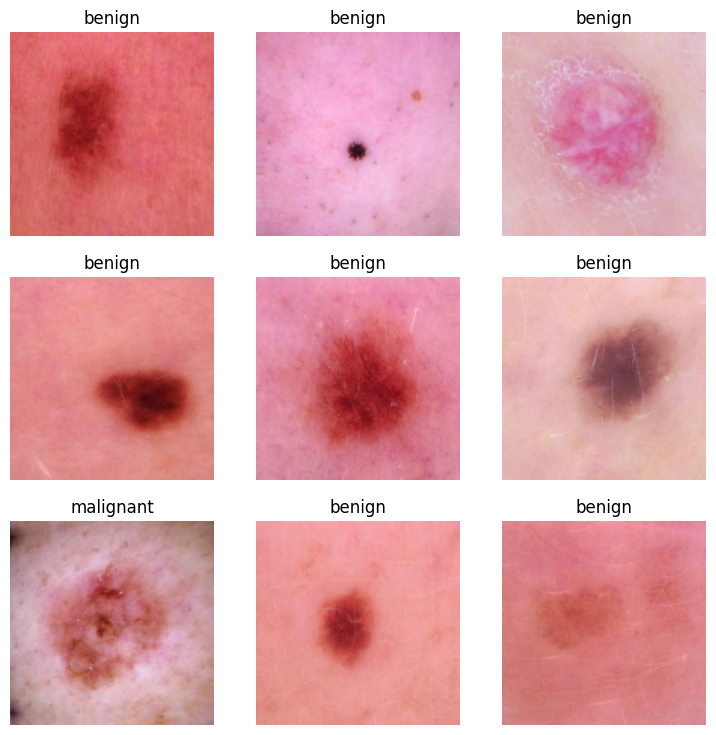

In [11]:
dls.show_batch()

# Train a simple model

In [12]:
learn = vision_learner(dls, resnet34, pretrained=False,metrics=accuracy)
learn.fine_tune(3)


epoch,train_loss,valid_loss,accuracy,time
0,0.567740,0.340644,0.908606,00:42


epoch,train_loss,valid_loss,accuracy,time
0,0.364463,0.269330,0.910607,00:43
1,0.305855,0.246007,0.909273,00:43
2,0.255753,0.229853,0.909273,00:44


*The model achieved a strong performance with 91% accuracy after 3 epochs. The consistent decrease in training and validation loss indicates good learning and proper generalization.*

# Interpret the model

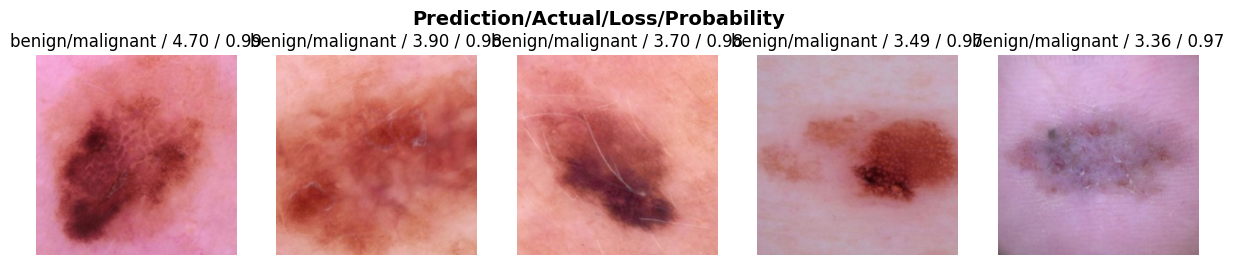

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5, nrows=1)

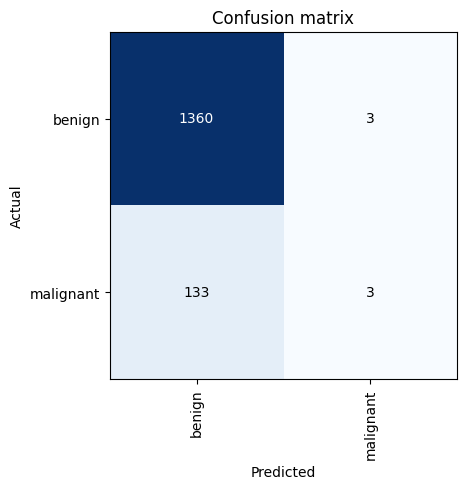

In [14]:
interp.plot_confusion_matrix()

# Learning Rate Finder

SuggestedLRs(valley=0.0002754228771664202)

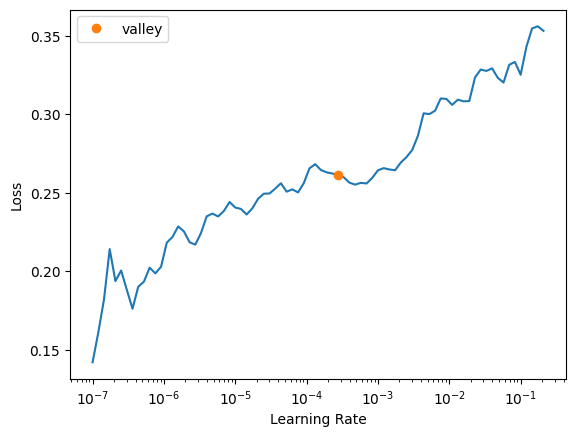

In [15]:
learn.lr_find()

**SuggestedLRs(valley=0.0002754228771664202) ≈ 2.75e-4**


# Transfer Learning

In [16]:
# only the last layer training
learn.freeze()
learn.fit_one_cycle(1, lr_max=2.75e-4)



epoch,train_loss,valid_loss,accuracy,time
0,0.253285,0.227885,0.909273,00:37


In [17]:
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(1e-5, 2.75e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.274739,0.236338,0.895931,00:43
1,0.239137,0.222761,0.910607,00:43
2,0.251040,0.226155,0.909940,00:44
3,0.238686,0.223849,0.910607,00:44


The model is learning in a stable way. Although validation loss slightly increased in epoch 3, there is no serious overfitting.
Epoch 2 seems to be the most effective point, with the lowest validation loss and the highest accuracy.  

*EarlyStoppingCallback was not used in this project because it may conflict with the learning rate finder (lr_find). It can stop training early before the optimal learning rate shows its full effect. Therefore, a fixed number of epochs was used instead, as recommended in the course instructions.*

# Mixed Precision Training

In [18]:
#learn = vision_learner(dls, resnet50, pretrained=False, metrics=accuracy)
learn = learn.to_fp16()

# Discriminative Learning Rate

In [19]:
learn.freeze()
learn.fit_one_cycle(1, lr_max=2e-3)


/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,0.243554,0.227850,0.909273,00:34


In [20]:
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(1e-6, 2e-3)) 


epoch,train_loss,valid_loss,accuracy,time
0,0.257908,0.222675,0.911941,00:35
1,0.254299,0.219029,0.909273,00:34
2,0.238971,0.219307,0.912608,00:34
3,0.225597,0.218650,0.911274,00:35


We compared ResNet34 and ResNet50 on the ISIC 2018 dataset.  


# Exporting the Model

In [26]:
learn.export('new_skin_lesion_model.pkl')


In [27]:
#convert the model back to full 32-bit precision using to_fp32() to ensure compatibility during inference. 
learn.to_fp32()
learn.export('new_skin_lesion_model.pkl')


In [28]:
import os
print(os.listdir())


['.virtual_documents', 'new_skin_lesion_model.pkl', 'skin_lesion_model.pkl', '.gradio', 'models']


# Gradio Interface


In [24]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 86.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.3 MB/s eta 0:00:00


In [29]:
import gradio as gr

learn_inf = load_learner('new_skin_lesion_model.pkl')

def predict(img):
    pred, pred_idx, probs = learn_inf.predict(img)
    return {learn_inf.dls.vocab[i]: float(probs[i]) for i in range(len(probs))}

gr.Interface(fn=predict, 
             inputs=gr.Image(type="pil"), 
             outputs=gr.Label(num_top_classes=2),
             title="Skin Lesion Classifier").launch()


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


* Running on local URL:  http://127.0.0.1:7861
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://3aa60118bbaf3a40a7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
